# 图像分割的应用


## 什么是图像分割？


在之前的笔记中，我们仅讨论了图像**分类**问题，即从一张图像中预测其所属类别（例如，“这是数字5的图像”或“这是猫的图像”）。
然而，图像分析还包括另外两大类任务：**目标检测**和**图像分割**。


### 图像中的目标检测


图像中的**目标检测**是指在图像中**定位并框选**特定目标。例如，若目标是检测猫，而图像中同时包含一只狗和一只猫，则模型需学习在猫的周围绘制一个边界框（bounding box）。

下图展示了目标检测的直观示例：

![目标检测示例](./images/detection.png)
*图片来源：[Machinethink 博客](https://machinethink.net/blog/object-detection-with-yolo/)*


如您所见，目标检测在图像处理领域具有重要应用价值，但**本笔记将不深入探讨该主题**。


### 图像中的目标分割


**图像分割**的目标是确定图像中**每个像素**所属的类别（例如，“位置为(120, 300)的像素属于狗”）。它旨在**像素级别**上精确提取图像内容信息。

下图展示了分割任务的典型输出：

![分割示例](./images/Segmentation.png)
*图片来源：[Towards AI 博客](https://towardsai.net/p/l/machine-learning-7)*


图像分割主要包括以下几种类型：
- **语义分割（Semantic Segmentation）**：
  对图像中**每个像素**进行类别标注，**忽略实例区分**（例如，所有汽车均标记为红色）。上图即为语义分割的示例。
- **实例分割（Instance Segmentation）**：
  对**同一类别的不同实例**分别标注（例如，第一辆车标红色，第二辆车标橙色）。
- 其他分割技术（如全景分割）可参考：
  [《计算机视觉中的图像分割技术》](https://medium.com/@arulkumarark1924/image-segmentation-techniques-for-computer-vision-bc5a68a4aa10)


**本笔记将以语义分割为例**进行实践。


## 使用的数据集


本实验采用 [Oxford-IIIT 宠物数据集](https://www.robots.ox.ac.uk/~vgg/data/pets/)，共包含 **7349 张图像**（4978 张狗图像 + 2371 张猫图像）。每张图像均提供：
- 分割标注（pixel-level）
- 宠物头部的边界框（bounding box）

数据集示例如下：

![Oxford 宠物数据集示例](./images/oxford_pet.jpg)


**本实验仅使用宠物分割标注**（忽略头部边界框信息）。


**数据集获取说明**：
需从[官方网站](https://www.robots.ox.ac.uk/~vgg/data/pets/)下载完整数据集，因 `torchvision` 提供的版本**不包含分割掩膜**（segmentation masks）。


若目标数据集**未收录在 `torchvision`** 中，需**自定义 `Dataset` 子类**，以实现数据的加载与预处理逻辑。


In [7]:
# Import nécessaire pour le projet
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import numpy as np

In [ ]:
class datasetSeg(Dataset):
  def __init__(self, path):
    self.path = path
    self.imagesPath,self.masksPath=self.loadDataset()
    
    self.resize=T.Resize((100, 100)) # Valeur de resize pour les images
    self.toTensor=T.ToTensor()
  
  def __len__(self):
    return len(self.imagesPath)
  
  def loadDataset(self): # Récuperation des liens vers les images et les annotations
    images=os.listdir(self.path+"images/")
    images=sorted(images)
    masks=os.listdir(self.path+"annotations/trimaps/")
    masks=sorted(masks)
    masks=[ mask for mask in masks if "._" not in mask ]
    images=[image for image in images if ".mat" not in image]
    return images, masks
  
  def __getitem__(self, index):
    image=Image.open(self.path+"images/"+self.imagesPath[index]).convert('RGB')
    # Resize des images et récuperation du masque de segmentation
    trimap=self.resize(Image.open(self.path+"annotations/trimaps/"+self.masksPath[index]).convert('L'))
    trimap=np.array(trimap)
    # Création des masques pour les classes
    class1 = (trimap == 1).astype(np.uint8)  
    class2 = (trimap == 2).astype(np.uint8)  
    class3 = (trimap == 3).astype(np.uint8)
    mask = np.stack([class1, class2, class3], axis=0)
    return self.toTensor(self.resize(image)), torch.tensor(mask)
        

**数据集准备完成**。接下来，我们将加载数据集并探索其内容。


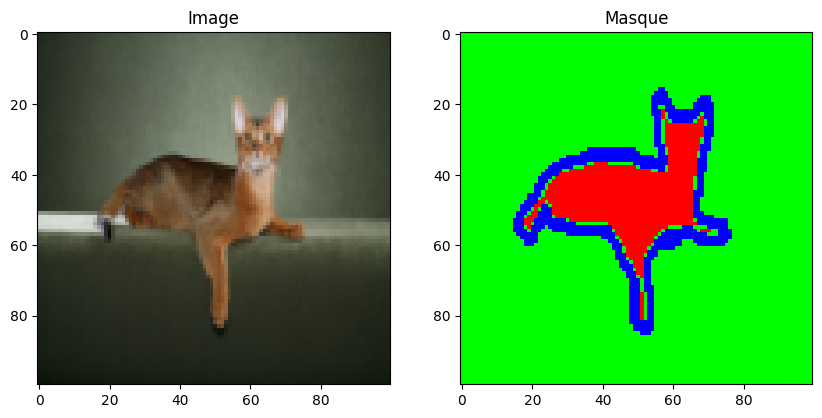

In [9]:
dataset=datasetSeg(path="./../data/OxfordPets/")
img=dataset[0][0].permute(1,2,0).numpy()
msk = dataset[0][1].permute(1, 2, 0).numpy() * 1.0

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img)
axs[0].set_title('Image')
axs[1].imshow(msk)
axs[1].set_title('Masque')
plt.show()

我们已成功加载**图像及其对应的分割掩膜**。接下来，我们将：
1. 划分训练/测试集
2. 定义 `DataLoader`


In [10]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset,[0.7, 0.2, 0.1])
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True)

## 模型架构：U-Net


与图像分类不同，**分割任务的输出**必须满足：
- **空间分辨率**与输入一致（例如，输入为 $224 \times 224 \times 3$，输出为 $224 \times 224 \times \text{类别数}$）。
- 每个通道对应一个待分割类别（例如 10 类分割任务输出 10 通道）。

传统 CNN（如逐步降采样至全连接层的分类网络）**无法直接适用**，因其破坏了空间结构。为此，我们采用 **U-Net 架构**。


U-Net 的架构示意如下：

![U-Net 架构图](./images/unet.png)
*图片来源：[Data Science Today 博客](https://datasciencetoday.net/index.php/en-us/deep-learning/228-unet)*


U-Net 的设计独特，由两部分组成：
1. **收缩路径（Encoder）**：
   类似传统 CNN，通过下采样逐步**缩小特征图尺寸**，提取高层语义信息。
2. **扩展路径（Decoder）**：
   通过上采样**恢复特征图尺寸**，最终输出与输入分辨率一致的分割结果。

**关键设计**：
- **跳跃连接（Skip Connections）**：
  将 encoder 各层的特征图直接传递给 decoder 对应层，保留**局部细节信息**。
- **encoder/decoder 结合**：
  同时捕获**高层语义**与**低层纹理**特征。

U-Net 最早应用于**医学图像分割**（[Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)），现已广泛用于分割、去噪、扩散模型等领域。


### 转置卷积（Transposed Convolution）简介


我们已学习了**标准卷积层**，其通过可学习参数对图像进行操作，并可通过 `stride` 参数**保持或降低分辨率**。
然而，在某些场景（如 U-Net 的 decoder）中，我们需要**提升特征图分辨率**。此时，标准卷积无法满足需求。


常见的上采样方法包括：
1. **插值 + 卷积**：
   先使用**非可训练插值**（如双线性插值）放大图像，再应用标准卷积。类似于 pooling 的逆操作。
2. **转置卷积（Transposed Convolution）**：
   作为卷积的“逆操作”，可通过可学习参数**直接扩大特征图尺寸**。下图展示了 $2 \times 2$ 核的转置卷积示例：

   ![转置卷积示意图](./images/convT.png)
   *图片来源：[D2L 计算机视觉教程](https://d2l.ai/chapter_computer-vision/transposed-conv.html)*


对两种方法的技术细节及优劣对比感兴趣的读者，可参阅：
[《转置卷积与棋盘伪影》](https://distill.pub/2016/deconv-checkerboard/)

**本实验将采用转置卷积**实现上采样。


### PyTorch 实现


接下来，我们将基于 PyTorch **实现 U-Net 架构**。


In [11]:
# Fonction pour combiner couche de convolution, activation ReLU et BatchNorm pour éviter les copier coller 
def conv_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )
    
# Idem mais avec la convolution transposée
def convT_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )

class UNet(nn.Module):
  def __init__(self, num_classes=3):
    super().__init__()
    # encoder
    self.conv1=conv_relu_bn(3, 64, 3, 1, 1)
    self.conv2=conv_relu_bn(64, 64, 3, 1, 1)
    self.maxPool1=nn.MaxPool2d(2, 2)
    
    self.conv3=conv_relu_bn(64, 128, 3, 1, 1)
    self.conv4=conv_relu_bn(128, 128, 3, 1, 1)
    self.maxPool2=nn.MaxPool2d(2, 2)
    
    #Module central
    self.conv5=conv_relu_bn(128, 256, 3, 1, 1)
    self.conv6=conv_relu_bn(256, 256, 3, 1, 1)
    
    # Décodeur
    self.convT1=convT_relu_bn(256, 128, 4, 2, 1)
    self.conv7=conv_relu_bn(256, 128, 3, 1, 1)
    
    self.convT2=convT_relu_bn(128, 64, 4, 2, 1)
    self.conv8=conv_relu_bn(128, 64, 3, 1, 1)
    
    # On va prédire un channel par classe
    self.conv9=conv_relu_bn(64, num_classes, 3, 1, 1)     
    self.sigmoid=nn.Sigmoid()
  
  def forward(self,x):
    # Encodeur
    x=self.conv1(x)
    x1=self.conv2(x)
    
    x=self.maxPool1(x1)
    
    x=self.conv3(x)
    x2=self.conv4(x)
    x=self.maxPool2(x2)
    
    # Module central
    x=self.conv5(x)
    x=self.conv6(x)

    #Décodeur
    x=self.convT1(x)
    x=torch.cat((x,x2),dim=1)
    x=self.conv7(x)
    
    x=self.convT2(x)
    x=torch.cat((x,x1),dim=1)
    x=self.conv8(x)
    
    x=self.conv9(x)
    x=self.sigmoid(x)
    return x

## 模型训练


**训练目标**：
本实验**不区分猫狗类别**，仅将像素划分为 3 类：
- 宠物主体像素
- 边界像素
- 背景像素


In [12]:
# Nous défissons
model=UNet(num_classes=3).to('cuda')
criterion=nn.CrossEntropyLoss()
lr=0.001
optimizer=torch.optim.Adam(model.parameters(), lr=lr)
epochs=5

**训练注意事项**：
- 数据集规模较大，模型较深，若 GPU 性能有限，训练可能需**数十分钟**。
- **不建议在无 GPU 环境下尝试训练**。


In [13]:
for epoch in range(epochs):
  train_loss=0
  for images,masks in train_dataloader:
    images=images.to('cuda')
    masks=masks.to('cuda').float()
    optimizer.zero_grad()
    seg=model(images)
    loss=criterion(seg,masks)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  print(f"step {epoch} train loss {train_loss/len(train_dataloader)}")  
  val_loss=0
  for images,masks in val_dataloader:
    images=images.to('cuda')
    masks=masks.to('cuda').float()
    with torch.no_grad():
      seg=model(images)
      loss=criterion(seg,masks)
    val_loss += loss.item() 
  print(f"step {epoch} train loss {val_loss/len(val_dataloader)}")  

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


step 0 train loss 0.9442852522120063
step 0 train loss 0.9016501573806114
step 1 train loss 0.8738441905121744
step 1 train loss 0.8578698165873264
step 2 train loss 0.8354099944785789
step 2 train loss 0.8258832287281117
step 3 train loss 0.8052123431806211
step 3 train loss 0.7977393028583932
step 4 train loss 0.7819347337440208
step 4 train loss 0.7781971261856404


训练完成后，我们将在**测试集上计算模型精度**。


In [14]:
def calculate_class_accuracy(preds, masks, class_idx):
  #On convertit les prédictions en valeur entre 0 et 1 pour chaque classe
  preds = torch.argmax(preds, dim=1)
  
  # On ne récupère que les pixels de la classe d'intêret
  preds_class = (preds == class_idx).float()
  masks_class = (masks == class_idx).float()
  
  # Calculer la précision pour la classe choisie
  correct = (preds_class == masks_class).float()
  accuracy = correct.sum() / correct.numel()
  return accuracy

model.eval()
test_accuracy = 0.0
num_batches = 0


with torch.no_grad(): # Désactivation du calcul du gradient
  for images, masks in test_dataloader:
    images = images.to('cuda')
    masks = masks.to('cuda').long()
    
    seg = model(images)
    
    # On calcule la précision pour la classe d'intêret (0 correspond à la segmentation de l'animal)
    class_idx = 0
    batch_accuracy = calculate_class_accuracy(seg, masks, class_idx)
    
    test_accuracy += batch_accuracy.item()
    num_batches += 1

# On calcule la précision moyenne sur l'ensemble du dataset de test
test_accuracy /= num_batches
print(f'Précision pour la segmentation de l animal : {test_accuracy*100:.1f}%')

Précision pour la segmentation de l animal : 43.4%


### 结果可视化


我们将从测试集中随机选取图像，可视化模型的分割结果。对于分割任务，**直观检查个别样本**的输出尤为重要。
**运行多次下方代码块**，可查看不同图像的分割效果。


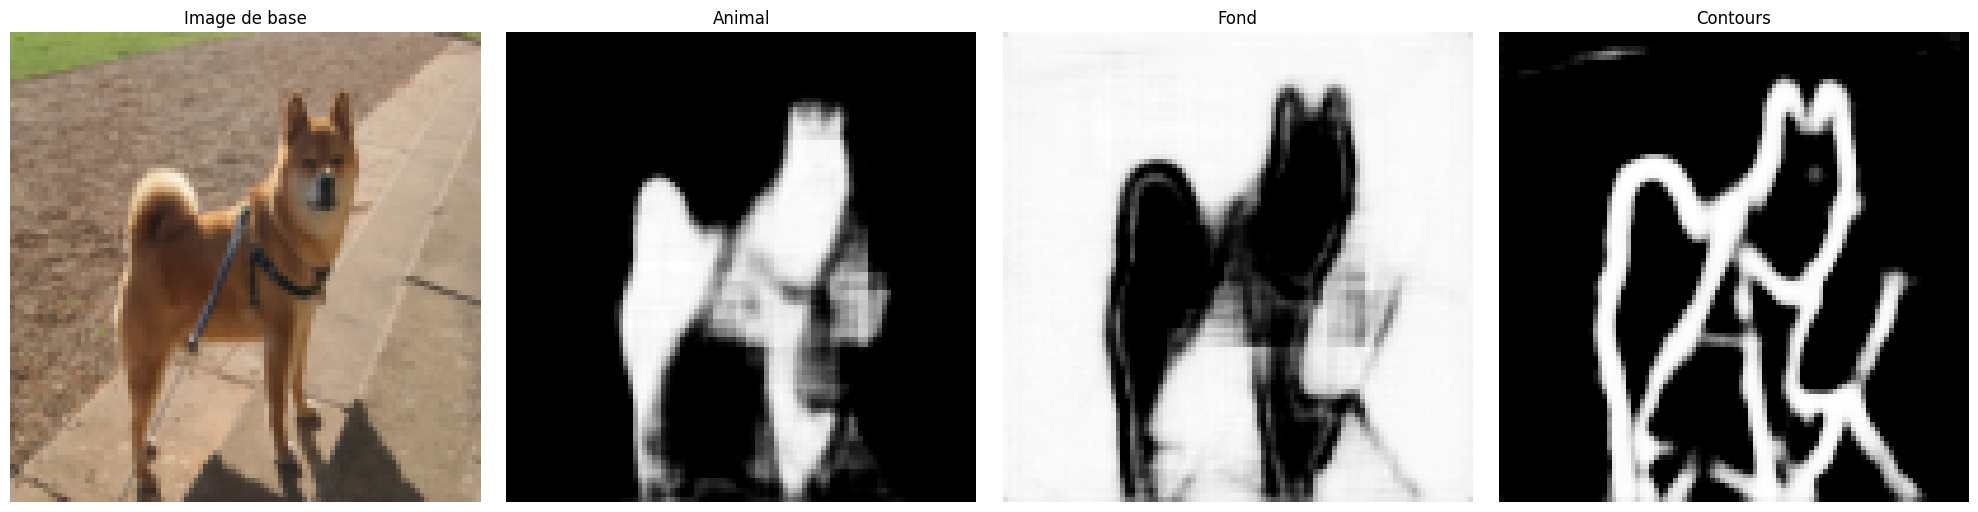

In [32]:
images,labels=next(iter(test_dataloader))

#Isolons un élément 
image=images[0].unsqueeze(0).to('cuda') # Le unsqueeze permet de garder la dimension batch
with torch.no_grad():
  seg=model(image)
    
# Affichons la segmentation prédite par le modèle pour cet élément
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Image de base')
axs[0].axis('off')

axs[1].imshow(seg[0][0].cpu().numpy(), cmap='gray')
axs[1].set_title('Animal')
axs[1].axis('off')

axs[2].imshow(seg[0][1].cpu().numpy(), cmap='gray')
axs[2].set_title('Fond')
axs[2].axis('off')

axs[3].imshow(seg[0][2].cpu().numpy(), cmap='gray')
axs[3].set_title('Contours')
axs[3].axis('off')

plt.tight_layout()
plt.show()

虽然整体精度仅为 **43%**，但**大多数图像的分割结果仍较为准确**。


### 实践练习


为提升模型性能，您可以尝试以下优化策略：
- 调整网络结构：
  增加/减少层数、修改各层通道数
- 添加正则化：
  `Dropout`、`BatchNorm`
- 调整训练超参数：
  增加 `epochs`、调整学习率 (`learning rate`)

**目标**：最大化分割模型的性能指标！**
